In [1]:
import sys
import os

# Add the project root to the Python path
project_root = os.path.abspath("..")  # assumes notebook is in notebooks/
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Import strategy
import pandas as pd
import matplotlib.pyplot as plt
from strategy.sell_strangle import sell_strangle

In [3]:
# Read BTC enriched data + Options chain
df = pd.read_csv("../data/btc-price-enriched.csv", parse_dates=['Date'])
df.set_index('Date', inplace=True)

option_chain = pd.read_csv("../data/options_chain.csv")

In [4]:
# Print results head
results = sell_strangle(option_chain, df)
results.head()

,entry_date,expiry_date,spot_entry,spot_expiry,strike,call_premium,put_premium,total_premium,call_loss,put_loss,pnl
0,2017-01-15,2017-01-22,821.797974,924.672974,800,63.55,45.28,108.83,124.672974,0.00000,-15.842974
1,2017-01-22,2017-01-29,924.672974,919.495972,900,41.64,20.78,62.42,19.495972,0.00000,42.924028
2,2017-01-29,2017-02-05,919.495972,1027.339966,900,25.61,9.67,35.28,127.339966,0.00000,-92.059966
3,2017-02-05,2017-02-12,1027.339966,999.181030,1000,35.07,11.61,46.68,0.000000,0.81897,45.861030
4,2017-02-12,2017-02-19,999.181030,1047.869995,1000,25.30,30.53,55.83,47.869995,0.00000,7.960005


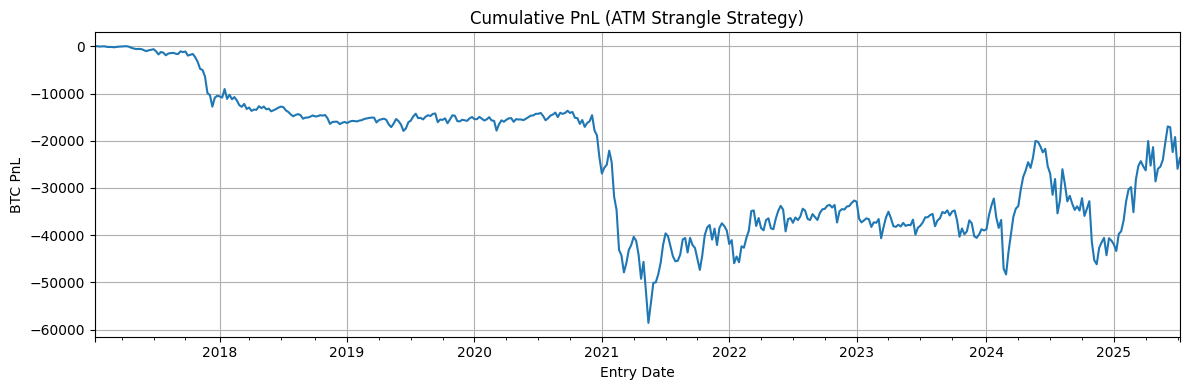

In [5]:
# Compute and plot cumulative BTC PnL over time.
# This shows how the strategy performs from a wealth-building perspective.
# The cumulative PnL assumes each weekly strangle position's PnL is reinvested.

results['cumulative_pnl'] = results['pnl'].cumsum()

plt.figure(figsize=(12, 4))
results.set_index('entry_date')['cumulative_pnl'].plot()
plt.title("Cumulative PnL (ATM Strangle Strategy)")
plt.xlabel("Entry Date")
plt.ylabel("BTC PnL")
plt.grid(True)

# Save the plot
plt.tight_layout()
plt.savefig("../docs/figures/sell_strangle_cumulative_pnl.png", dpi=150)
plt.show()

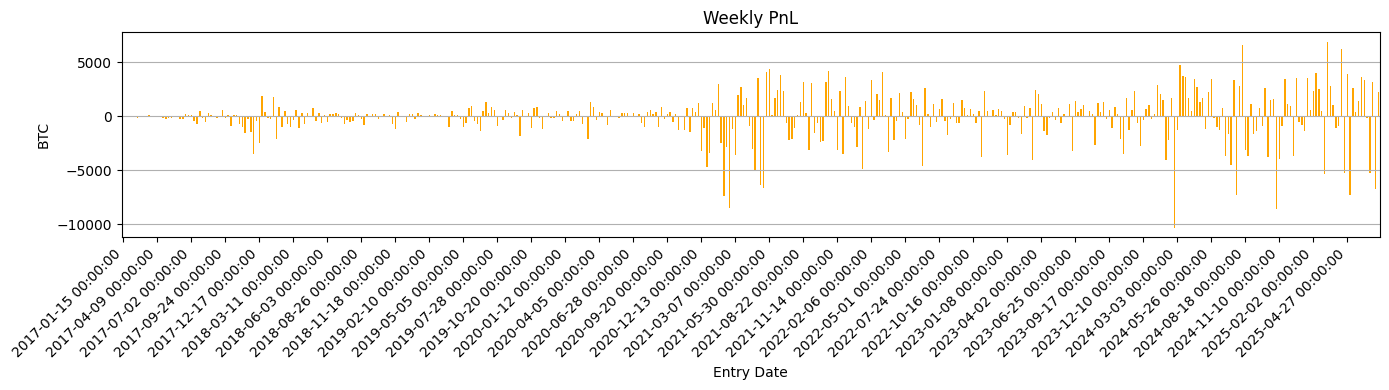

In [6]:
import matplotlib.dates as mdates

# Plot weekly BTC PnL for the short strangle strategy.
# Each bar represents the PnL from one weekly option position (entry to expiry).
# Helps identify volatility clusters, extreme losses, and consistency of gains/losses.
# X-axis ticks are spaced for readability (~quarterly) with rotated labels.

plt.figure(figsize=(14, 4))
ax = results.set_index('entry_date')['pnl'].plot(kind='bar', color='orange')

# Format x-axis: show every Nth tick and rotate labels
ax.set_title("Weekly PnL")
ax.set_ylabel("BTC")
ax.set_xlabel("Entry Date")

# Set x-ticks every 12 bars (~3 months if weekly)
tick_spacing = 12
ax.set_xticks(ax.get_xticks()[::tick_spacing])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.grid(True, axis='y')

# Save the plot
plt.tight_layout()
plt.savefig("../docs/figures/sell_strangle_weekly_pnl.png", dpi=150)
plt.show()


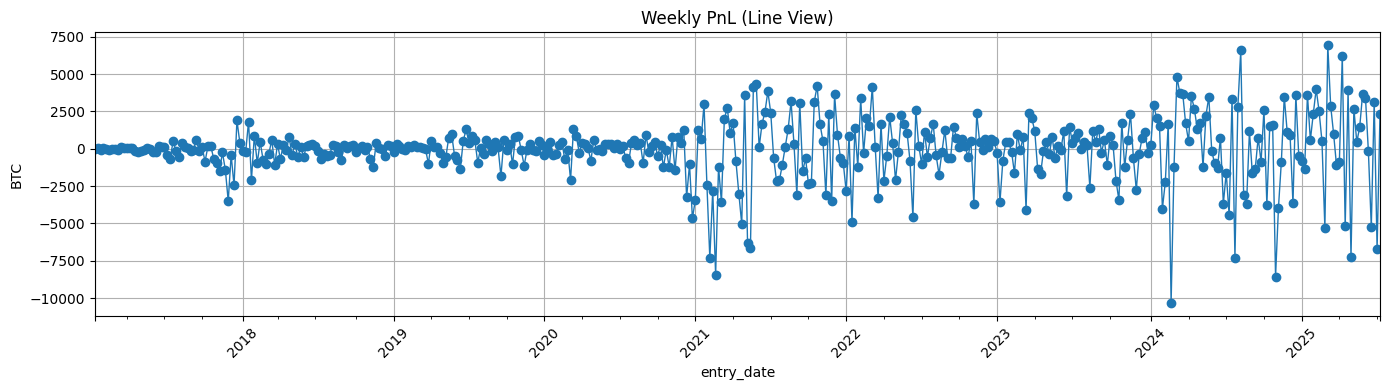

In [7]:
# Plot weekly BTC-denominated PnL as a line chart with markers.
# This alternative view helps visualize the continuity, clustering, and magnitude
# of weekly PnL over time — especially useful for spotting:
# - Volatility clusters (tight or erratic PnL swings)
# - Periods of calm or consistent gain/loss
# - Visual outliers or regime shifts
# This is a good complement to the bar chart, offering a smoother, time-continuous perspective.

plt.figure(figsize=(14, 4))
results.set_index('entry_date')['pnl'].plot(marker='o', linewidth=1)
plt.title("Weekly PnL (Line View)")
plt.ylabel("BTC")
plt.grid(True)
plt.xticks(rotation=45)

# Save the plot
plt.tight_layout()
plt.savefig("../docs/figures/sell_strangle_weekly_pnl_line.png", dpi=150)
plt.show()

/tmp/ipykernel_29857/1981343471.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


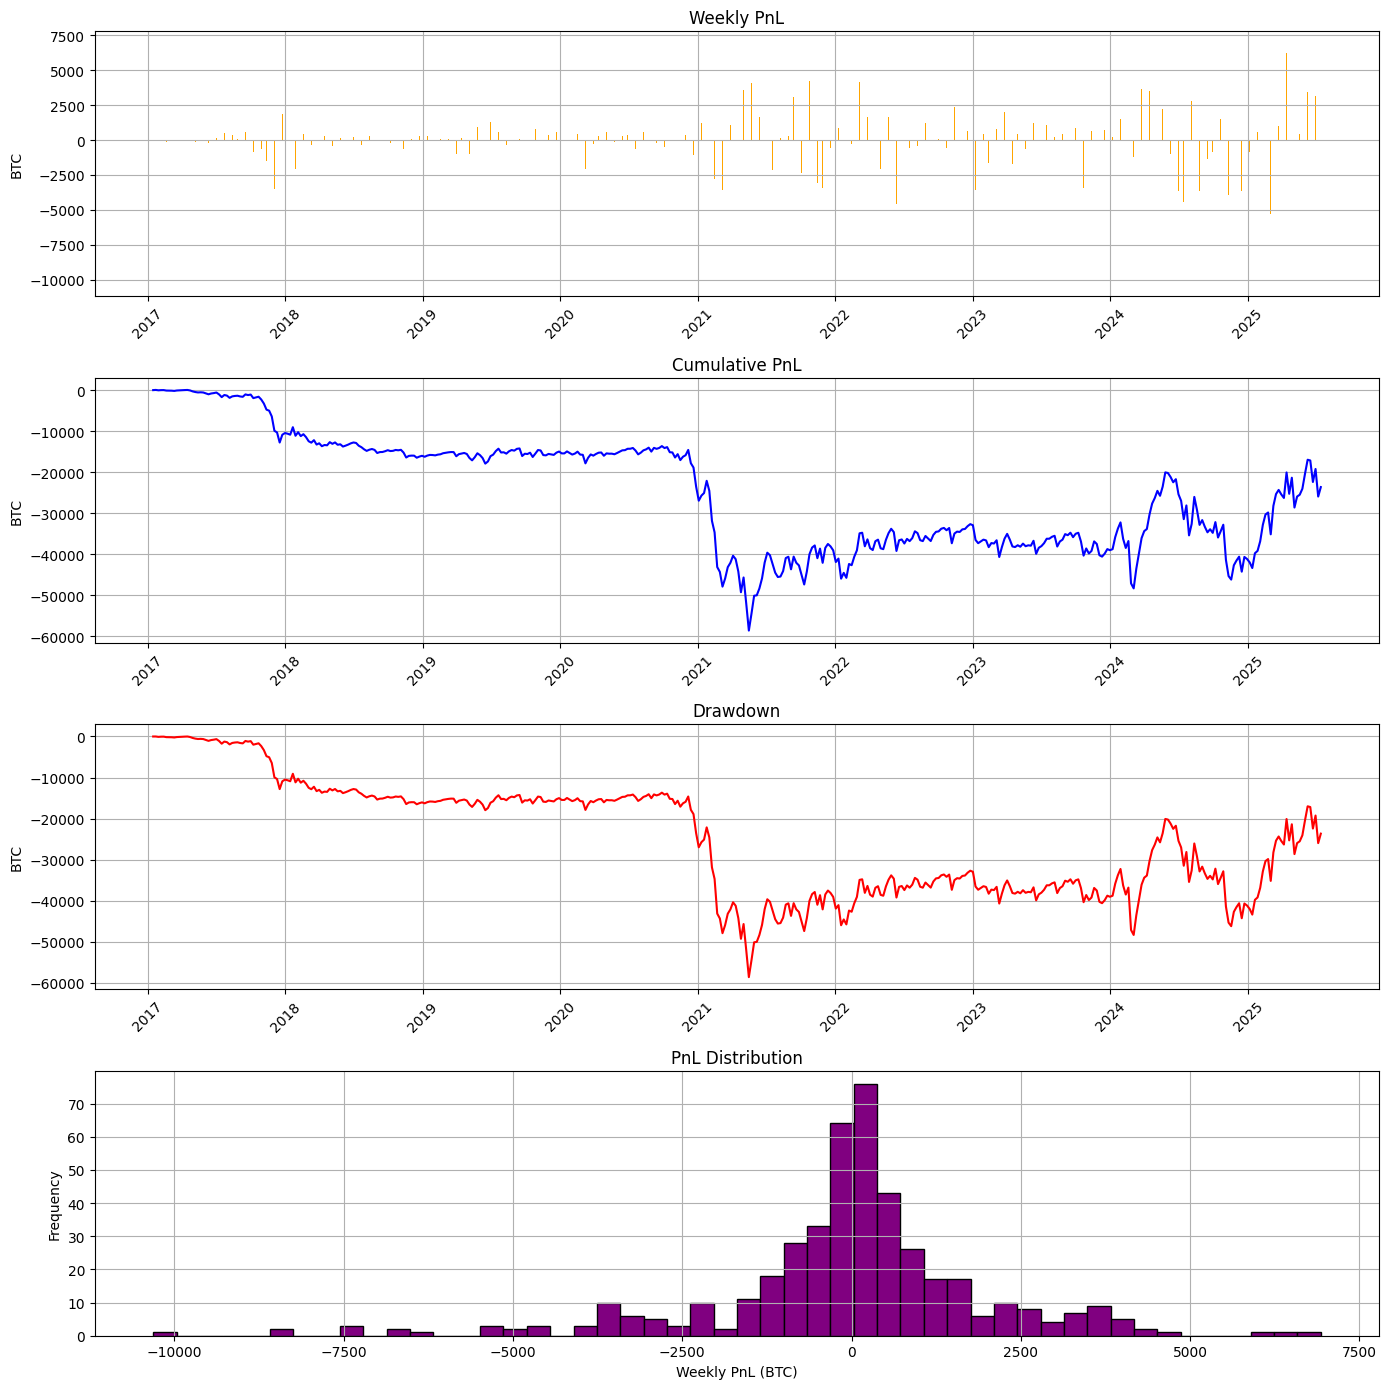

In [8]:
import matplotlib.pyplot as plt

# Visualize the core performance diagnostics of the short strangle strategy.
# This 4-panel chart shows:
# 1. Weekly PnL: Captures week-to-week gains and losses.
# 2. Cumulative PnL: Tracks long-term BTC-denominated performance assuming reinvestment.
# 3. Drawdown: Measures peak-to-trough losses to assess risk and capital erosion.
# 4. PnL Distribution: Displays the frequency and symmetry of weekly outcomes.
# Together, these charts provide an overview of profitability, volatility, downside risk, and payoff shape.

# Compute cumulative and drawdown
results['cumulative_pnl'] = results['pnl'].cumsum()
results['rolling_max'] = results['cumulative_pnl'].cummax()
results['drawdown'] = results['cumulative_pnl'] - results['rolling_max']

# Create 3 + 1 separate axis (disable sharex for the histogram)
fig, axs = plt.subplots(4, 1, figsize=(14, 14), 
                        gridspec_kw={'height_ratios': [1, 1, 1, 1]}, 
                        constrained_layout=True)

# 1. Weekly PnL
axs[0].bar(results['entry_date'], results['pnl'], color='orange')
axs[0].set_title("Weekly PnL")
axs[0].set_ylabel("BTC")
axs[0].grid(True)

# 2. Cumulative PnL
axs[1].plot(results['entry_date'], results['cumulative_pnl'], color='blue')
axs[1].set_title("Cumulative PnL")
axs[1].set_ylabel("BTC")
axs[1].grid(True)

# 3. Drawdown
axs[2].plot(results['entry_date'], results['drawdown'], color='red')
axs[2].set_title("Drawdown")
axs[2].set_ylabel("BTC")
axs[2].grid(True)

# 4. Histogram — avoid datetime on x-axis
axs[3].hist(results['pnl'].values, bins=50, color='purple', edgecolor='black')
axs[3].set_title("PnL Distribution")
axs[3].set_xlabel("Weekly PnL (BTC)")
axs[3].set_ylabel("Frequency")
axs[3].grid(True)

# Rotate x-axis for time-series plots
for ax in axs[:3]:
    ax.tick_params(axis='x', rotation=45)

# Save the plot
plt.tight_layout()
plt.savefig("../docs/figures/sell_strangle_4_chart_panel.png", dpi=150)
plt.show()


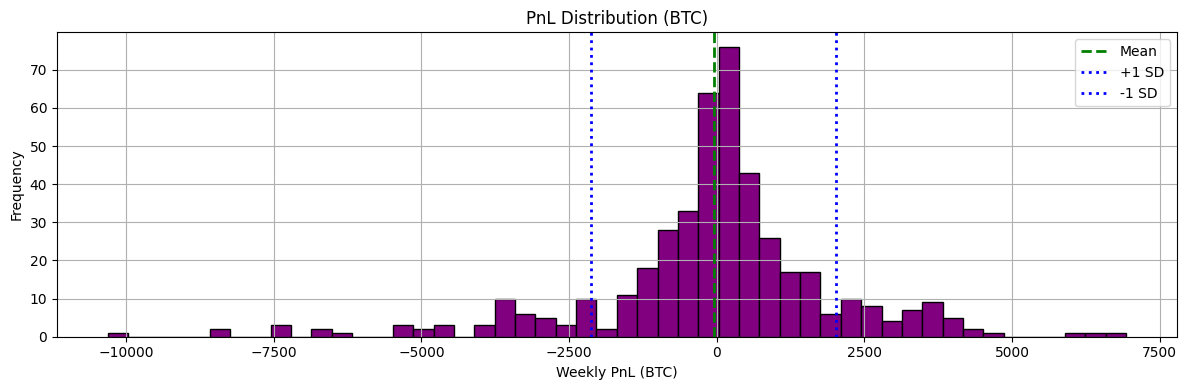

In [9]:
# Enhance the PnL distribution plot with statistical annotations.
# The green dashed line shows the mean weekly PnL, while blue dotted lines mark +/- 1 standard deviation.
# This contextualises how typical or extreme each week’s return is and visually conveys the strategy's risk asymmetry.

import matplotlib.pyplot as plt

# Compute statistics
mean = results['pnl'].mean()
std = results['pnl'].std()

# Create histogram
plt.figure(figsize=(12, 4))
plt.hist(results['pnl'], bins=50, color='purple', edgecolor='black')

# Add reference lines
plt.axvline(mean, color='green', linestyle='--', linewidth=2, label='Mean')
plt.axvline(mean + std, color='blue', linestyle=':', linewidth=2, label='+1 SD')
plt.axvline(mean - std, color='blue', linestyle=':', linewidth=2, label='-1 SD')

# Labels and title
plt.title("PnL Distribution (BTC)")
plt.xlabel("Weekly PnL (BTC)")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()

# Save image
plt.tight_layout()
plt.savefig("../docs/figures/sell_strangle_pnl_distribution_annotated.png", dpi=150)
plt.show()


In [10]:
import numpy as np

# Compute key performance metrics for the strategy.
# 1. Sharpe Ratio — Risk-adjusted return assuming weekly PnL; annualized to standardize across time frames.
# 2. Win Rate — Proportion of weeks with positive PnL, indicating consistency.
# 3️. Max Drawdown (%) — Largest peak-to-trough decline in cumulative BTC terms, measuring downside risk.
# 4. BTC Balance (Equity Curve) — Simulates strategy growth assuming 1 BTC starting capital.
# These metrics provide an at-a-glance summary of strategy quality in terms of risk, return, and capital growth.

# 1. Sharpe Ratio
mean_return = results['pnl'].mean()
std_return = results['pnl'].std()
sharpe_ratio = (mean_return / std_return) * np.sqrt(52)  # weekly -> annualized

# 2. Win Rate
win_rate = (results['pnl'] > 0).sum() / len(results)

# 3. Max Drawdown (%)
results['cumulative_pnl'] = results['pnl'].cumsum()
results['rolling_max'] = results['cumulative_pnl'].cummax()
results['drawdown'] = results['cumulative_pnl'] - results['rolling_max']
max_drawdown_pct = (results['drawdown'].min() / results['rolling_max'].max()) * 100

# 4. Equity Curve (BTC-denominated balance)
starting_btc = 1
results['btc_balance'] = starting_btc + results['cumulative_pnl']

# 📊 Print summary
print("- Sharpe Ratio      :", round(sharpe_ratio, 2))
print("- Win Rate          :", f"{win_rate:.1%}")
print("- Max Drawdown %    :", f"{max_drawdown_pct:.2f}%")
print("- Final BTC Balance :", round(results['btc_balance'].iloc[-1], 4))


- Sharpe Ratio      : -0.19
- Win Rate          : 54.3%
- Max Drawdown %    : -216390.68%
- Final BTC Balance : -23632.0023


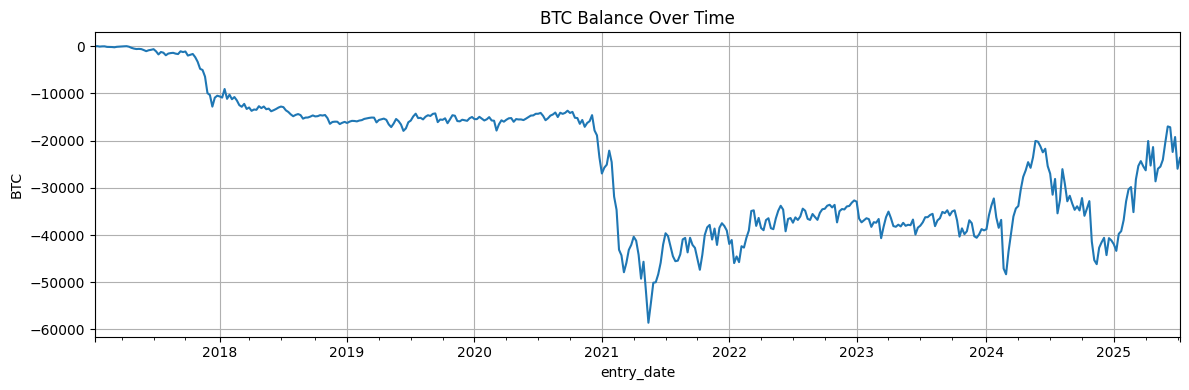

In [11]:
# Plot the BTC equity curve.
# This shows how the portfolio BTC balance evolves over the life of the strategy,
# assuming an initial 1 BTC starting capital and reinvestment of all PnL.
# It provides a cumulative view of strategy performance, reflecting compounding gains/losses.

plt.figure(figsize=(12, 4))
results.set_index('entry_date')['btc_balance'].plot()
plt.title("BTC Balance Over Time")
plt.ylabel("BTC")
plt.grid(True)
# Save image (optional)
plt.tight_layout()
plt.savefig("../docs/figures/sell_strangle_btc_equity_curve.png", dpi=150)
plt.show()